In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    make_scorer,
    roc_curve,
    auc,
    recall_score,
)

import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from eli5.sklearn import PermutationImportance

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-12 06:37:27.834958: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-12 06:37:27.875660: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 06:37:30.878849: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Tenso

In [2]:
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

In [3]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [4]:
# 데이터 불러오기
train = pd.read_csv('./data/train_preprocess.csv')
test = pd.read_csv('./data/test_preprocess.csv')

In [5]:
train['pallet'] = train['pallet'].astype('int64')
test['pallet'] = test['pallet'].astype('int64')

In [6]:
# 각 영역별 
dam = ['target', 'inconsistant', 'dam_cure_position', 'model_suffix', 
      'cure_speed_dam', 'discharged_speed_dam', 'cid_time_dam', 'seq_time_dam',
       'cluster_time_dam', 'cid_volume_dam', 'Seq_volume_dam',
       'cluster_volume_dam', 'distance_diff_cid_seq_dam',
       'distance_diff_seq_cluster_dam', 'dam_time', 'pallet', 'qty', 'receip',
       'Stage1 Circle1 Distance Speed Collect Result_Dam',
       'Stage1 Circle2 Distance Speed Collect Result_Dam',
       'Stage1 Circle3 Distance Speed Collect Result_Dam',
       'Stage1 Circle4 Distance Speed Collect Result_Dam',
       'Stage1 Line1 Distance Speed Collect Result_Dam',
       'Stage1 Line2 Distance Speed Collect Result_Dam',
       'Stage1 Line3 Distance Speed Collect Result_Dam',
       'Stage1 Line4 Distance Speed Collect Result_Dam',
       'Stage2 Circle1 Distance Speed Collect Result_Dam',
       'Stage2 Circle2 Distance Speed Collect Result_Dam',
       'Stage2 Circle3 Distance Speed Collect Result_Dam',
       'Stage2 Circle4 Distance Speed Collect Result_Dam',
       'Stage2 Line1 Distance Speed Collect Result_Dam',
       'Stage2 Line2 Distance Speed Collect Result_Dam',
       'Stage2 Line3 Distance Speed Collect Result_Dam',
       'Stage2 Line4 Distance Speed Collect Result_Dam',
       'Stage3 Circle1 Distance Speed Collect Result_Dam',
       'Stage3 Circle2 Distance Speed Collect Result_Dam',
       'Stage3 Circle3 Distance Speed Collect Result_Dam',
       'Stage3 Circle4 Distance Speed Collect Result_Dam',
       'Stage3 Line1 Distance Speed Collect Result_Dam',
       'Stage3 Line2 Distance Speed Collect Result_Dam',
       'Stage3 Line3 Distance Speed Collect Result_Dam',
       'Stage3 Line4 Distance Speed Collect Result_Dam', 'thickness_set']
fill1 = ['target', 'inconsistant', 'dam_cure_position', 'model_suffix', 
        'discharged_speed_fill1',
       'cid_time_fill1', 'seq_time_fill1', 'cluster_time_fill1',
       'cid_volume_fill1', 'Seq_volume_fill1', 'cluster_volume_fill1',
       'distance_diff_cid_seq_fill1', 'distance_diff_seq_cluster_fill1',
         'pallet', 'qty', 'receip', 'fill1_time'
        ]
fill2 = [
    'target', 'inconsistant', 'dam_cure_position', 'model_suffix',
         'distance_diff_cid_seq_fill2', 'distance_diff_seq_cluster_fill2',
         'fill2_cure_position', 'fill2_time',
       'pallet', 'qty', 'receip'
]
autoclave = ['target', 'inconsistant', 'dam_cure_position', 'model_suffix',
            '1st Pressure Collect Result_AutoClave',
           '2nd Pressure Collect Result_AutoClave',
           '3rd Pressure Collect Result_AutoClave',
           'Chamber Temp. Collect Result_AutoClave', 'autoclave_time', 
           'pallet', 'qty', 'receip'
            ]

df_dam = train[dam]
df_fill1 = train[fill1]
df_fill2 = train[fill2]
df_autoclave = train[autoclave]

# DAM

In [7]:
X_dam = df_dam.drop(columns=['target'])
y_dam = df_dam['target'].apply(lambda x: 0 if x == 'Normal' else 1)

cat_features_indices = ['model_suffix', 'pallet', 'receip']

X_train, X_valid, y_train, y_valid = train_test_split(X_dam, y_dam, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-12 06:37:37,754] A new study created in memory with name: no-name-0ca86e0d-1e5f-4a02-a049-c61228598dfa
[I 2024-08-12 06:38:00,806] Trial 0 finished with value: 0.5319691766302044 and parameters: {'iterations': 986, 'depth': 9, 'learning_rate': 0.006372568682414447, 'l2_leaf_reg': 9.441605390313958, 'border_count': 118, 'random_strength': 1.4677344063840838, 'bagging_temperature': 0.6915113089466401, 'od_type': 'IncToDec', 'od_wait': 33, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.5319691766302044.
[I 2024-08-12 06:38:06,364] Trial 1 finished with value: 0.5339838098853553 and parameters: {'iterations': 927, 'depth': 9, 'learning_rate': 0.097404395921055, 'l2_leaf_reg': 4.796260725837866, 'border_count': 129, 'random_strength': 9.950361954028828, 'bagging_temperature': 0.5458772561641552, 'od_type': 'Iter', 'od_wait': 45, 'boosting_type': 'Plain'}. Best is trial 1 with value: 0.5339838098853553.
[I 2024-08-12 06:38:08,307] Trial 2 finished with value: 0.535854443

[I 2024-08-12 06:41:03,834] Trial 20 finished with value: 0.5319691766302044 and parameters: {'iterations': 205, 'depth': 8, 'learning_rate': 0.04714447456887195, 'l2_leaf_reg': 9.321435865105844, 'border_count': 128, 'random_strength': 2.453632596730496, 'bagging_temperature': 0.7633743574472356, 'od_type': 'Iter', 'od_wait': 39, 'boosting_type': 'Ordered'}. Best is trial 6 with value: 0.5439345836625671.
[I 2024-08-12 06:41:11,814] Trial 21 finished with value: 0.5359902158932616 and parameters: {'iterations': 507, 'depth': 7, 'learning_rate': 0.1633494853615776, 'l2_leaf_reg': 6.128491872958071, 'border_count': 32, 'random_strength': 4.11223107593976, 'bagging_temperature': 0.010210534990586329, 'od_type': 'IncToDec', 'od_wait': 20, 'boosting_type': 'Ordered'}. Best is trial 6 with value: 0.5439345836625671.
[I 2024-08-12 06:41:14,722] Trial 22 finished with value: 0.5359902158932616 and parameters: {'iterations': 667, 'depth': 7, 'learning_rate': 0.6712704091082436, 'l2_leaf_reg': 

[I 2024-08-12 06:45:42,144] Trial 40 finished with value: 0.5359902158932616 and parameters: {'iterations': 473, 'depth': 5, 'learning_rate': 0.038820676259592755, 'l2_leaf_reg': 0.9881743787595094, 'border_count': 114, 'random_strength': 1.4679151260124286, 'bagging_temperature': 0.4971968387366622, 'od_type': 'IncToDec', 'od_wait': 17, 'boosting_type': 'Ordered'}. Best is trial 6 with value: 0.5439345836625671.
[I 2024-08-12 06:45:58,656] Trial 41 finished with value: 0.5319691766302044 and parameters: {'iterations': 871, 'depth': 5, 'learning_rate': 0.026480126193018243, 'l2_leaf_reg': 2.921132926360018, 'border_count': 231, 'random_strength': 8.369709067757325, 'bagging_temperature': 0.4299730521163899, 'od_type': 'IncToDec', 'od_wait': 22, 'boosting_type': 'Ordered'}. Best is trial 6 with value: 0.5439345836625671.
[I 2024-08-12 06:46:02,758] Trial 42 finished with value: 0.5359902158932616 and parameters: {'iterations': 993, 'depth': 4, 'learning_rate': 0.2620040820065018, 'l2_le

Best trial:
  Value: 0.5439345836625671
  Params: 
    iterations: 706
    depth: 5
    learning_rate: 0.5396611757419573
    l2_leaf_reg: 5.683872716040322
    border_count: 69
    random_strength: 1.2027784516716105
    bagging_temperature: 0.6696329788849343
    od_type: Iter
    od_wait: 24
    boosting_type: Plain


In [8]:
study.best_trial.params

{'iterations': 706,
 'depth': 5,
 'learning_rate': 0.5396611757419573,
 'l2_leaf_reg': 5.683872716040322,
 'border_count': 69,
 'random_strength': 1.2027784516716105,
 'bagging_temperature': 0.6696329788849343,
 'od_type': 'Iter',
 'od_wait': 24,
 'boosting_type': 'Plain'}

In [9]:
# 최적의 하이퍼파라미터로 모델 재학습
dam_best_params = study.best_trial.params
dam_best_model = CatBoostClassifier(**dam_best_params)
dam_best_model.fit(X_train, y_train, cat_features=cat_features_indices)

0:	learn: 0.2791187	total: 14.3ms	remaining: 10.1s
1:	learn: 0.2247799	total: 27.3ms	remaining: 9.6s
2:	learn: 0.2126155	total: 41.7ms	remaining: 9.77s
3:	learn: 0.2097532	total: 53.8ms	remaining: 9.45s
4:	learn: 0.2089294	total: 67.5ms	remaining: 9.46s
5:	learn: 0.2084821	total: 80.7ms	remaining: 9.41s
6:	learn: 0.2078038	total: 94.1ms	remaining: 9.4s
7:	learn: 0.2071818	total: 107ms	remaining: 9.37s
8:	learn: 0.2066506	total: 121ms	remaining: 9.4s
9:	learn: 0.2063028	total: 136ms	remaining: 9.44s
10:	learn: 0.2057543	total: 152ms	remaining: 9.59s
11:	learn: 0.2055455	total: 167ms	remaining: 9.68s
12:	learn: 0.2055273	total: 180ms	remaining: 9.59s
13:	learn: 0.2049060	total: 194ms	remaining: 9.57s
14:	learn: 0.2048326	total: 203ms	remaining: 9.34s
15:	learn: 0.2042512	total: 218ms	remaining: 9.4s
16:	learn: 0.2040667	total: 232ms	remaining: 9.4s
17:	learn: 0.2039638	total: 244ms	remaining: 9.31s
18:	learn: 0.2039638	total: 250ms	remaining: 9.06s
19:	learn: 0.2035949	total: 263ms	remai

168:	learn: 0.1801692	total: 2.24s	remaining: 7.13s
169:	learn: 0.1800146	total: 2.26s	remaining: 7.13s
170:	learn: 0.1797961	total: 2.27s	remaining: 7.12s
171:	learn: 0.1796415	total: 2.29s	remaining: 7.11s
172:	learn: 0.1794299	total: 2.31s	remaining: 7.11s
173:	learn: 0.1793479	total: 2.32s	remaining: 7.1s
174:	learn: 0.1792945	total: 2.34s	remaining: 7.09s
175:	learn: 0.1792314	total: 2.35s	remaining: 7.08s
176:	learn: 0.1791673	total: 2.37s	remaining: 7.07s
177:	learn: 0.1789987	total: 2.38s	remaining: 7.06s
178:	learn: 0.1789380	total: 2.39s	remaining: 7.05s
179:	learn: 0.1788022	total: 2.41s	remaining: 7.04s
180:	learn: 0.1787694	total: 2.42s	remaining: 7.03s
181:	learn: 0.1785400	total: 2.44s	remaining: 7.01s
182:	learn: 0.1785339	total: 2.45s	remaining: 7s
183:	learn: 0.1784888	total: 2.46s	remaining: 6.99s
184:	learn: 0.1784085	total: 2.48s	remaining: 6.97s
185:	learn: 0.1784037	total: 2.49s	remaining: 6.95s
186:	learn: 0.1781464	total: 2.5s	remaining: 6.94s
187:	learn: 0.177

333:	learn: 0.1621366	total: 4.51s	remaining: 5.02s
334:	learn: 0.1620263	total: 4.52s	remaining: 5.01s
335:	learn: 0.1618526	total: 4.54s	remaining: 4.99s
336:	learn: 0.1618158	total: 4.55s	remaining: 4.98s
337:	learn: 0.1617633	total: 4.56s	remaining: 4.97s
338:	learn: 0.1617618	total: 4.58s	remaining: 4.95s
339:	learn: 0.1617252	total: 4.59s	remaining: 4.94s
340:	learn: 0.1616445	total: 4.6s	remaining: 4.92s
341:	learn: 0.1615843	total: 4.61s	remaining: 4.91s
342:	learn: 0.1615496	total: 4.63s	remaining: 4.9s
343:	learn: 0.1614555	total: 4.64s	remaining: 4.88s
344:	learn: 0.1614036	total: 4.66s	remaining: 4.87s
345:	learn: 0.1612750	total: 4.67s	remaining: 4.86s
346:	learn: 0.1611591	total: 4.68s	remaining: 4.84s
347:	learn: 0.1610195	total: 4.7s	remaining: 4.83s
348:	learn: 0.1609234	total: 4.71s	remaining: 4.82s
349:	learn: 0.1607484	total: 4.72s	remaining: 4.81s
350:	learn: 0.1606792	total: 4.74s	remaining: 4.79s
351:	learn: 0.1606517	total: 4.75s	remaining: 4.78s
352:	learn: 0.1

498:	learn: 0.1481601	total: 6.79s	remaining: 2.82s
499:	learn: 0.1480705	total: 6.81s	remaining: 2.81s
500:	learn: 0.1480495	total: 6.82s	remaining: 2.79s
501:	learn: 0.1479336	total: 6.83s	remaining: 2.78s
502:	learn: 0.1478510	total: 6.85s	remaining: 2.76s
503:	learn: 0.1477970	total: 6.86s	remaining: 2.75s
504:	learn: 0.1477530	total: 6.88s	remaining: 2.74s
505:	learn: 0.1476511	total: 6.89s	remaining: 2.72s
506:	learn: 0.1476505	total: 6.91s	remaining: 2.71s
507:	learn: 0.1476503	total: 6.92s	remaining: 2.69s
508:	learn: 0.1475668	total: 6.93s	remaining: 2.68s
509:	learn: 0.1474577	total: 6.94s	remaining: 2.67s
510:	learn: 0.1474196	total: 6.95s	remaining: 2.65s
511:	learn: 0.1473872	total: 6.97s	remaining: 2.64s
512:	learn: 0.1473403	total: 6.98s	remaining: 2.63s
513:	learn: 0.1473321	total: 6.99s	remaining: 2.61s
514:	learn: 0.1472975	total: 7.01s	remaining: 2.6s
515:	learn: 0.1471049	total: 7.02s	remaining: 2.58s
516:	learn: 0.1470856	total: 7.04s	remaining: 2.57s
517:	learn: 0

666:	learn: 0.1366209	total: 9.1s	remaining: 532ms
667:	learn: 0.1364703	total: 9.11s	remaining: 518ms
668:	learn: 0.1363442	total: 9.13s	remaining: 505ms
669:	learn: 0.1363098	total: 9.14s	remaining: 491ms
670:	learn: 0.1362508	total: 9.15s	remaining: 477ms
671:	learn: 0.1362366	total: 9.17s	remaining: 464ms
672:	learn: 0.1362000	total: 9.18s	remaining: 450ms
673:	learn: 0.1360972	total: 9.2s	remaining: 437ms
674:	learn: 0.1360811	total: 9.21s	remaining: 423ms
675:	learn: 0.1360641	total: 9.22s	remaining: 409ms
676:	learn: 0.1360468	total: 9.24s	remaining: 396ms
677:	learn: 0.1359811	total: 9.25s	remaining: 382ms
678:	learn: 0.1359621	total: 9.27s	remaining: 368ms
679:	learn: 0.1359611	total: 9.28s	remaining: 355ms
680:	learn: 0.1358456	total: 9.29s	remaining: 341ms
681:	learn: 0.1358267	total: 9.3s	remaining: 327ms
682:	learn: 0.1357794	total: 9.32s	remaining: 314ms
683:	learn: 0.1356474	total: 9.34s	remaining: 300ms
684:	learn: 0.1356286	total: 9.35s	remaining: 287ms
685:	learn: 0.1

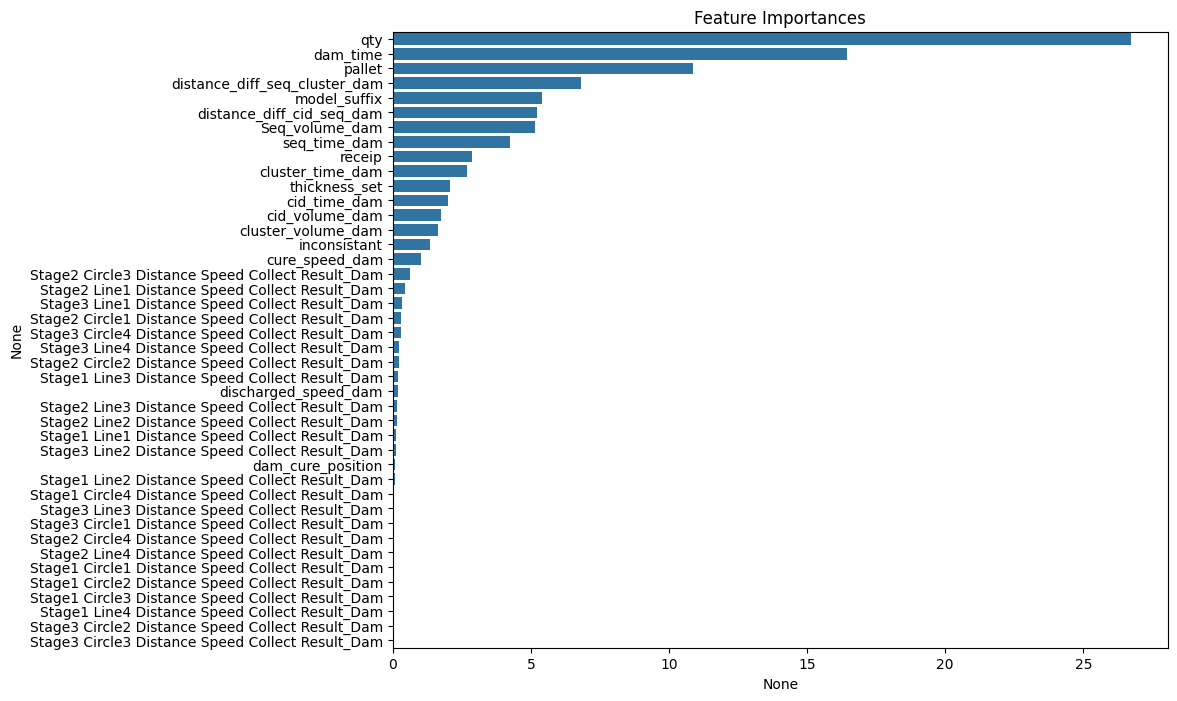

In [10]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(dam_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [11]:
pred = dam_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  30  428]
 [   9 7635]]

정확도: 0.9461
정밀도: 0.7692
재현율: 0.0655
F1: 0.1207


# Fill1

In [12]:
X_fill1 = df_fill1.drop(columns=['target'])
y_fill1 = df_fill1['target'].apply(lambda x: 0 if x == 'Normal' else 1)

cat_features_indices = ['model_suffix', 'pallet', 'receip']

X_train, X_valid, y_train, y_valid = train_test_split(X_fill1, y_fill1, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-12 06:47:01,205] A new study created in memory with name: no-name-bd66ac04-cf96-4b35-98a8-82bda2ba17a3
[I 2024-08-12 06:47:09,670] Trial 0 finished with value: 0.5319691766302044 and parameters: {'iterations': 324, 'depth': 7, 'learning_rate': 0.016734714806049336, 'l2_leaf_reg': 1.7335949291813078, 'border_count': 221, 'random_strength': 7.1143822038415845, 'bagging_temperature': 0.9590455980398375, 'od_type': 'IncToDec', 'od_wait': 28, 'boosting_type': 'Ordered'}. Best is trial 0 with value: 0.5319691766302044.
[I 2024-08-12 06:47:26,138] Trial 1 finished with value: 0.5319691766302044 and parameters: {'iterations': 684, 'depth': 7, 'learning_rate': 0.016486260021326773, 'l2_leaf_reg': 6.677503646481566, 'border_count': 204, 'random_strength': 7.724486059732314, 'bagging_temperature': 0.6936915476495223, 'od_type': 'Iter', 'od_wait': 22, 'boosting_type': 'Ordered'}. Best is trial 0 with value: 0.5319691766302044.
[I 2024-08-12 06:47:29,046] Trial 2 finished with value: 0.5

[I 2024-08-12 06:48:54,210] Trial 20 finished with value: 0.5359902158932616 and parameters: {'iterations': 273, 'depth': 6, 'learning_rate': 0.08023656794427515, 'l2_leaf_reg': 5.650027714772383, 'border_count': 139, 'random_strength': 9.319268075267694, 'bagging_temperature': 0.570816214264045, 'od_type': 'Iter', 'od_wait': 23, 'boosting_type': 'Ordered'}. Best is trial 18 with value: 0.5374325580836299.
[I 2024-08-12 06:48:59,957] Trial 21 finished with value: 0.5359902158932616 and parameters: {'iterations': 450, 'depth': 8, 'learning_rate': 0.22974837546232785, 'l2_leaf_reg': 2.3622944422125394, 'border_count': 135, 'random_strength': 2.310558126476363, 'bagging_temperature': 0.0448269972214911, 'od_type': 'Iter', 'od_wait': 31, 'boosting_type': 'Ordered'}. Best is trial 18 with value: 0.5374325580836299.
[I 2024-08-12 06:49:03,425] Trial 22 finished with value: 0.5379884457800178 and parameters: {'iterations': 410, 'depth': 6, 'learning_rate': 0.2683502553768076, 'l2_leaf_reg': 1

[I 2024-08-12 06:50:20,858] Trial 40 finished with value: 0.5359902158932616 and parameters: {'iterations': 484, 'depth': 4, 'learning_rate': 0.27392356165922904, 'l2_leaf_reg': 2.902825343551781, 'border_count': 72, 'random_strength': 3.5094150829889332, 'bagging_temperature': 0.8982652179067594, 'od_type': 'Iter', 'od_wait': 26, 'boosting_type': 'Ordered'}. Best is trial 23 with value: 0.5399785502491956.
[I 2024-08-12 06:50:23,641] Trial 41 finished with value: 0.5359902158932616 and parameters: {'iterations': 551, 'depth': 7, 'learning_rate': 0.38604604704931167, 'l2_leaf_reg': 2.3866691165055354, 'border_count': 121, 'random_strength': 1.171976483897904, 'bagging_temperature': 0.8166288296367176, 'od_type': 'Iter', 'od_wait': 33, 'boosting_type': 'Ordered'}. Best is trial 23 with value: 0.5399785502491956.
[I 2024-08-12 06:50:25,586] Trial 42 finished with value: 0.5396921146733817 and parameters: {'iterations': 432, 'depth': 5, 'learning_rate': 0.6850298114663168, 'l2_leaf_reg': 

Best trial:
  Value: 0.5399785502491956
  Params: 
    iterations: 557
    depth: 5
    learning_rate: 0.49120279840722064
    l2_leaf_reg: 0.17874956381832163
    border_count: 89
    random_strength: 0.8537775943411564
    bagging_temperature: 0.750813055041675
    od_type: Iter
    od_wait: 39
    boosting_type: Ordered


In [13]:
study.best_trial.params

{'iterations': 557,
 'depth': 5,
 'learning_rate': 0.49120279840722064,
 'l2_leaf_reg': 0.17874956381832163,
 'border_count': 89,
 'random_strength': 0.8537775943411564,
 'bagging_temperature': 0.750813055041675,
 'od_type': 'Iter',
 'od_wait': 39,
 'boosting_type': 'Ordered'}

In [14]:
# 최적의 하이퍼파라미터로 모델 재학습
fill1_best_params = study.best_trial.params
fill1_best_model = CatBoostClassifier(**fill1_best_params)
fill1_best_model.fit(X_train, y_train, cat_features=cat_features_indices)

0:	learn: 0.2978506	total: 22.2ms	remaining: 12.3s
1:	learn: 0.2302204	total: 45.2ms	remaining: 12.5s
2:	learn: 0.2148636	total: 67.5ms	remaining: 12.5s
3:	learn: 0.2113032	total: 89.2ms	remaining: 12.3s
4:	learn: 0.2088398	total: 111ms	remaining: 12.2s
5:	learn: 0.2081462	total: 131ms	remaining: 12.1s
6:	learn: 0.2076022	total: 153ms	remaining: 12s
7:	learn: 0.2071790	total: 174ms	remaining: 11.9s
8:	learn: 0.2071615	total: 191ms	remaining: 11.6s
9:	learn: 0.2066125	total: 214ms	remaining: 11.7s
10:	learn: 0.2063153	total: 237ms	remaining: 11.8s
11:	learn: 0.2063153	total: 247ms	remaining: 11.2s
12:	learn: 0.2063153	total: 255ms	remaining: 10.7s
13:	learn: 0.2061591	total: 276ms	remaining: 10.7s
14:	learn: 0.2060667	total: 296ms	remaining: 10.7s
15:	learn: 0.2053069	total: 318ms	remaining: 10.7s
16:	learn: 0.2051619	total: 341ms	remaining: 10.8s
17:	learn: 0.2049067	total: 363ms	remaining: 10.9s
18:	learn: 0.2047474	total: 385ms	remaining: 10.9s
19:	learn: 0.2044877	total: 406ms	remai

162:	learn: 0.1801894	total: 3.59s	remaining: 8.67s
163:	learn: 0.1800432	total: 3.61s	remaining: 8.65s
164:	learn: 0.1799360	total: 3.63s	remaining: 8.63s
165:	learn: 0.1797798	total: 3.66s	remaining: 8.61s
166:	learn: 0.1796598	total: 3.67s	remaining: 8.58s
167:	learn: 0.1795877	total: 3.7s	remaining: 8.56s
168:	learn: 0.1794881	total: 3.72s	remaining: 8.54s
169:	learn: 0.1793631	total: 3.74s	remaining: 8.52s
170:	learn: 0.1793193	total: 3.76s	remaining: 8.5s
171:	learn: 0.1792971	total: 3.79s	remaining: 8.48s
172:	learn: 0.1790407	total: 3.81s	remaining: 8.46s
173:	learn: 0.1790138	total: 3.83s	remaining: 8.44s
174:	learn: 0.1788975	total: 3.85s	remaining: 8.41s
175:	learn: 0.1787196	total: 3.88s	remaining: 8.39s
176:	learn: 0.1785784	total: 3.9s	remaining: 8.37s
177:	learn: 0.1785164	total: 3.92s	remaining: 8.34s
178:	learn: 0.1784207	total: 3.94s	remaining: 8.32s
179:	learn: 0.1782298	total: 3.96s	remaining: 8.3s
180:	learn: 0.1780618	total: 3.99s	remaining: 8.28s
181:	learn: 0.17

328:	learn: 0.1676016	total: 7.22s	remaining: 5.01s
329:	learn: 0.1675970	total: 7.24s	remaining: 4.98s
330:	learn: 0.1675521	total: 7.26s	remaining: 4.96s
331:	learn: 0.1675193	total: 7.29s	remaining: 4.94s
332:	learn: 0.1675154	total: 7.3s	remaining: 4.91s
333:	learn: 0.1674958	total: 7.32s	remaining: 4.89s
334:	learn: 0.1674880	total: 7.34s	remaining: 4.87s
335:	learn: 0.1674358	total: 7.37s	remaining: 4.84s
336:	learn: 0.1673374	total: 7.39s	remaining: 4.82s
337:	learn: 0.1672421	total: 7.41s	remaining: 4.8s
338:	learn: 0.1672126	total: 7.43s	remaining: 4.78s
339:	learn: 0.1671992	total: 7.45s	remaining: 4.76s
340:	learn: 0.1671950	total: 7.47s	remaining: 4.73s
341:	learn: 0.1671220	total: 7.5s	remaining: 4.71s
342:	learn: 0.1671102	total: 7.51s	remaining: 4.69s
343:	learn: 0.1670929	total: 7.54s	remaining: 4.67s
344:	learn: 0.1669717	total: 7.56s	remaining: 4.64s
345:	learn: 0.1668945	total: 7.58s	remaining: 4.62s
346:	learn: 0.1668786	total: 7.6s	remaining: 4.6s
347:	learn: 0.166

488:	learn: 0.1604069	total: 10.6s	remaining: 1.48s
489:	learn: 0.1603804	total: 10.7s	remaining: 1.46s
490:	learn: 0.1603762	total: 10.7s	remaining: 1.44s
491:	learn: 0.1603689	total: 10.7s	remaining: 1.41s
492:	learn: 0.1603328	total: 10.7s	remaining: 1.39s
493:	learn: 0.1603045	total: 10.7s	remaining: 1.37s
494:	learn: 0.1603037	total: 10.8s	remaining: 1.35s
495:	learn: 0.1602455	total: 10.8s	remaining: 1.33s
496:	learn: 0.1602451	total: 10.8s	remaining: 1.3s
497:	learn: 0.1602314	total: 10.8s	remaining: 1.28s
498:	learn: 0.1601365	total: 10.8s	remaining: 1.26s
499:	learn: 0.1599704	total: 10.9s	remaining: 1.24s
500:	learn: 0.1599621	total: 10.9s	remaining: 1.22s
501:	learn: 0.1599532	total: 10.9s	remaining: 1.2s
502:	learn: 0.1599520	total: 10.9s	remaining: 1.17s
503:	learn: 0.1599502	total: 10.9s	remaining: 1.15s
504:	learn: 0.1599502	total: 11s	remaining: 1.13s
505:	learn: 0.1598720	total: 11s	remaining: 1.11s
506:	learn: 0.1598207	total: 11s	remaining: 1.08s
507:	learn: 0.159819

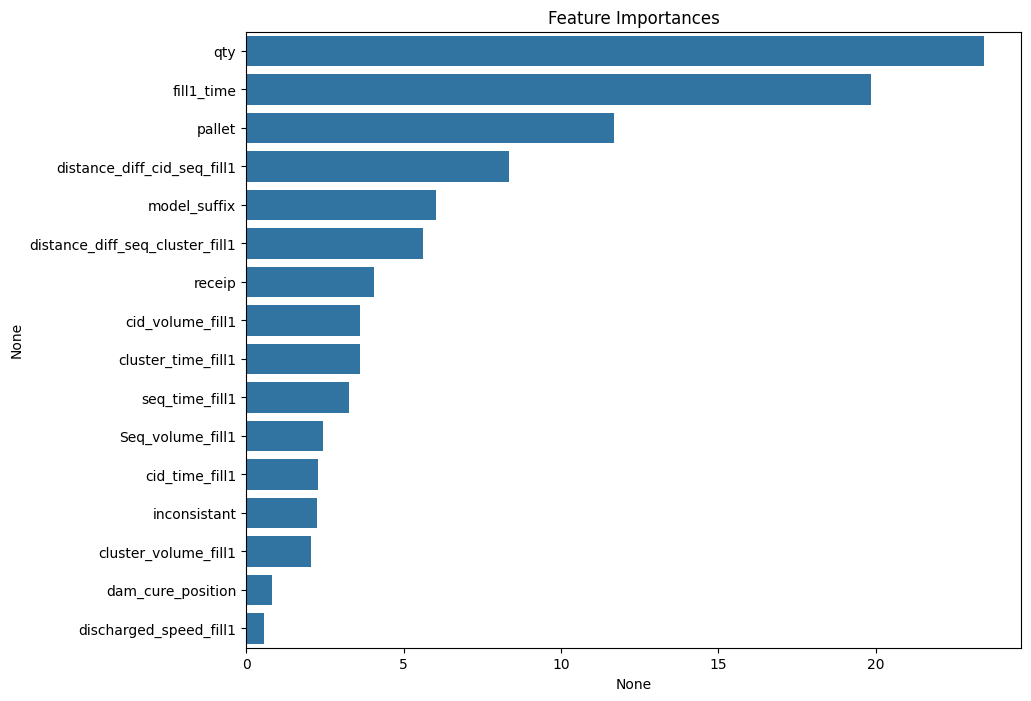

In [15]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(fill1_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [16]:
pred = fill1_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  34  424]
 [  41 7603]]

정확도: 0.9426
정밀도: 0.4533
재현율: 0.0742
F1: 0.1276


# Fill2

In [17]:
X_fill2 = df_fill2.drop(columns=['target'])
y_fill2 = df_fill2['target'].apply(lambda x: 0 if x == 'Normal' else 1)

cat_features_indices = ['model_suffix', 'pallet', 'receip']

X_train, X_valid, y_train, y_valid = train_test_split(X_fill2, y_fill2, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-12 06:51:08,374] A new study created in memory with name: no-name-ee0a13fb-382b-45f7-84f2-2b6b50360c62
[I 2024-08-12 06:51:17,612] Trial 0 finished with value: 0.5319691766302044 and parameters: {'iterations': 652, 'depth': 6, 'learning_rate': 0.03304094330188242, 'l2_leaf_reg': 9.475423041908474, 'border_count': 190, 'random_strength': 1.6795223595913678, 'bagging_temperature': 0.3846633156355749, 'od_type': 'Iter', 'od_wait': 24, 'boosting_type': 'Ordered'}. Best is trial 0 with value: 0.5319691766302044.
[I 2024-08-12 06:51:20,688] Trial 1 finished with value: 0.5319691766302044 and parameters: {'iterations': 218, 'depth': 8, 'learning_rate': 0.0049332220674019635, 'l2_leaf_reg': 5.382342445884006, 'border_count': 64, 'random_strength': 0.15942445407534783, 'bagging_temperature': 0.7388406080150706, 'od_type': 'Iter', 'od_wait': 20, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.5319691766302044.
[I 2024-08-12 06:51:22,276] Trial 2 finished with value: 0.5319691

[I 2024-08-12 06:53:06,314] Trial 20 finished with value: 0.5319691766302044 and parameters: {'iterations': 434, 'depth': 9, 'learning_rate': 0.14020329462549913, 'l2_leaf_reg': 1.7207033692297546, 'border_count': 185, 'random_strength': 6.36203816566057, 'bagging_temperature': 0.6823992761922675, 'od_type': 'Iter', 'od_wait': 38, 'boosting_type': 'Plain'}. Best is trial 11 with value: 0.5339838098853553.
[I 2024-08-12 06:53:17,098] Trial 21 finished with value: 0.5319691766302044 and parameters: {'iterations': 671, 'depth': 8, 'learning_rate': 0.004117312634349496, 'l2_leaf_reg': 4.52027944963776, 'border_count': 66, 'random_strength': 0.15298273033321852, 'bagging_temperature': 0.8881816642546232, 'od_type': 'Iter', 'od_wait': 20, 'boosting_type': 'Plain'}. Best is trial 11 with value: 0.5339838098853553.
[I 2024-08-12 06:53:20,790] Trial 22 finished with value: 0.5319691766302044 and parameters: {'iterations': 282, 'depth': 8, 'learning_rate': 0.005572207250024059, 'l2_leaf_reg': 5.

[I 2024-08-12 06:55:00,329] Trial 40 finished with value: 0.5319691766302044 and parameters: {'iterations': 954, 'depth': 6, 'learning_rate': 0.01861151455835611, 'l2_leaf_reg': 3.706303236360907, 'border_count': 132, 'random_strength': 4.012817919808814, 'bagging_temperature': 0.8532506362006737, 'od_type': 'IncToDec', 'od_wait': 23, 'boosting_type': 'Plain'}. Best is trial 24 with value: 0.5359902158932616.
[I 2024-08-12 06:55:05,492] Trial 41 finished with value: 0.5359902158932616 and parameters: {'iterations': 770, 'depth': 4, 'learning_rate': 0.031479669180505314, 'l2_leaf_reg': 0.12004446290144344, 'border_count': 101, 'random_strength': 5.7677642839057786, 'bagging_temperature': 0.6022704846301714, 'od_type': 'IncToDec', 'od_wait': 34, 'boosting_type': 'Plain'}. Best is trial 24 with value: 0.5359902158932616.
[I 2024-08-12 06:55:12,773] Trial 42 finished with value: 0.5319691766302044 and parameters: {'iterations': 744, 'depth': 5, 'learning_rate': 0.017232024523042472, 'l2_le

Best trial:
  Value: 0.5359902158932616
  Params: 
    iterations: 862
    depth: 6
    learning_rate: 0.04145130816352851
    l2_leaf_reg: 3.88925770568948
    border_count: 91
    random_strength: 2.6851215646865616
    bagging_temperature: 0.8734338205599486
    od_type: Iter
    od_wait: 23
    boosting_type: Plain


In [18]:
study.best_trial.params

{'iterations': 862,
 'depth': 6,
 'learning_rate': 0.04145130816352851,
 'l2_leaf_reg': 3.88925770568948,
 'border_count': 91,
 'random_strength': 2.6851215646865616,
 'bagging_temperature': 0.8734338205599486,
 'od_type': 'Iter',
 'od_wait': 23,
 'boosting_type': 'Plain'}

In [19]:
# 최적의 하이퍼파라미터로 모델 재학습
fill2_best_params = study.best_trial.params
fill2_best_model = CatBoostClassifier(**fill2_best_params)
fill2_best_model.fit(X_train, y_train, cat_features=cat_features_indices)

0:	learn: 0.6428028	total: 12ms	remaining: 10.4s
1:	learn: 0.5986332	total: 23.2ms	remaining: 9.99s
2:	learn: 0.5592335	total: 31.1ms	remaining: 8.89s
3:	learn: 0.5231156	total: 41.1ms	remaining: 8.81s
4:	learn: 0.4915455	total: 50.8ms	remaining: 8.7s
5:	learn: 0.4623707	total: 64.9ms	remaining: 9.26s
6:	learn: 0.4364291	total: 77.1ms	remaining: 9.42s
7:	learn: 0.4141799	total: 84.4ms	remaining: 9.01s
8:	learn: 0.3930522	total: 96.6ms	remaining: 9.16s
9:	learn: 0.3751380	total: 104ms	remaining: 8.89s
10:	learn: 0.3593043	total: 114ms	remaining: 8.83s
11:	learn: 0.3447322	total: 125ms	remaining: 8.88s
12:	learn: 0.3314359	total: 135ms	remaining: 8.81s
13:	learn: 0.3197459	total: 145ms	remaining: 8.75s
14:	learn: 0.3090671	total: 159ms	remaining: 8.97s
15:	learn: 0.2998284	total: 175ms	remaining: 9.25s
16:	learn: 0.2915516	total: 185ms	remaining: 9.21s
17:	learn: 0.2839926	total: 195ms	remaining: 9.13s
18:	learn: 0.2770635	total: 206ms	remaining: 9.15s
19:	learn: 0.2711443	total: 219ms	r

160:	learn: 0.2095253	total: 1.66s	remaining: 7.21s
161:	learn: 0.2095088	total: 1.67s	remaining: 7.21s
162:	learn: 0.2095081	total: 1.68s	remaining: 7.19s
163:	learn: 0.2094748	total: 1.69s	remaining: 7.2s
164:	learn: 0.2094748	total: 1.7s	remaining: 7.17s
165:	learn: 0.2094702	total: 1.71s	remaining: 7.15s
166:	learn: 0.2094702	total: 1.71s	remaining: 7.12s
167:	learn: 0.2094636	total: 1.72s	remaining: 7.11s
168:	learn: 0.2094348	total: 1.73s	remaining: 7.11s
169:	learn: 0.2094323	total: 1.74s	remaining: 7.08s
170:	learn: 0.2094051	total: 1.75s	remaining: 7.08s
171:	learn: 0.2093960	total: 1.76s	remaining: 7.07s
172:	learn: 0.2093960	total: 1.77s	remaining: 7.04s
173:	learn: 0.2093956	total: 1.77s	remaining: 7.02s
174:	learn: 0.2093904	total: 1.78s	remaining: 7s
175:	learn: 0.2093902	total: 1.79s	remaining: 6.99s
176:	learn: 0.2093882	total: 1.8s	remaining: 6.97s
177:	learn: 0.2093821	total: 1.81s	remaining: 6.96s
178:	learn: 0.2093628	total: 1.82s	remaining: 6.95s
179:	learn: 0.2093

322:	learn: 0.2058487	total: 3.5s	remaining: 5.84s
323:	learn: 0.2058246	total: 3.52s	remaining: 5.84s
324:	learn: 0.2057781	total: 3.53s	remaining: 5.83s
325:	learn: 0.2057403	total: 3.54s	remaining: 5.83s
326:	learn: 0.2056966	total: 3.56s	remaining: 5.82s
327:	learn: 0.2056787	total: 3.57s	remaining: 5.82s
328:	learn: 0.2056580	total: 3.59s	remaining: 5.81s
329:	learn: 0.2056183	total: 3.6s	remaining: 5.81s
330:	learn: 0.2055723	total: 3.62s	remaining: 5.8s
331:	learn: 0.2055223	total: 3.63s	remaining: 5.79s
332:	learn: 0.2054746	total: 3.64s	remaining: 5.79s
333:	learn: 0.2054607	total: 3.66s	remaining: 5.78s
334:	learn: 0.2054494	total: 3.67s	remaining: 5.78s
335:	learn: 0.2054124	total: 3.69s	remaining: 5.77s
336:	learn: 0.2053597	total: 3.7s	remaining: 5.77s
337:	learn: 0.2053255	total: 3.72s	remaining: 5.76s
338:	learn: 0.2053032	total: 3.73s	remaining: 5.76s
339:	learn: 0.2052660	total: 3.75s	remaining: 5.75s
340:	learn: 0.2052485	total: 3.76s	remaining: 5.75s
341:	learn: 0.20

484:	learn: 0.2017977	total: 5.77s	remaining: 4.49s
485:	learn: 0.2017830	total: 5.79s	remaining: 4.48s
486:	learn: 0.2017766	total: 5.8s	remaining: 4.47s
487:	learn: 0.2017480	total: 5.82s	remaining: 4.46s
488:	learn: 0.2017325	total: 5.83s	remaining: 4.45s
489:	learn: 0.2017087	total: 5.85s	remaining: 4.44s
490:	learn: 0.2017015	total: 5.86s	remaining: 4.43s
491:	learn: 0.2016773	total: 5.88s	remaining: 4.42s
492:	learn: 0.2016597	total: 5.89s	remaining: 4.41s
493:	learn: 0.2016096	total: 5.91s	remaining: 4.4s
494:	learn: 0.2015878	total: 5.92s	remaining: 4.39s
495:	learn: 0.2015504	total: 5.94s	remaining: 4.38s
496:	learn: 0.2015395	total: 5.95s	remaining: 4.37s
497:	learn: 0.2015060	total: 5.97s	remaining: 4.36s
498:	learn: 0.2014890	total: 5.98s	remaining: 4.35s
499:	learn: 0.2014600	total: 6s	remaining: 4.34s
500:	learn: 0.2014483	total: 6.01s	remaining: 4.33s
501:	learn: 0.2014179	total: 6.03s	remaining: 4.32s
502:	learn: 0.2014096	total: 6.04s	remaining: 4.31s
503:	learn: 0.201

644:	learn: 0.1989495	total: 8.05s	remaining: 2.71s
645:	learn: 0.1989266	total: 8.06s	remaining: 2.69s
646:	learn: 0.1989225	total: 8.08s	remaining: 2.68s
647:	learn: 0.1989162	total: 8.09s	remaining: 2.67s
648:	learn: 0.1989056	total: 8.11s	remaining: 2.66s
649:	learn: 0.1988972	total: 8.12s	remaining: 2.65s
650:	learn: 0.1988777	total: 8.13s	remaining: 2.64s
651:	learn: 0.1988690	total: 8.15s	remaining: 2.62s
652:	learn: 0.1988512	total: 8.16s	remaining: 2.61s
653:	learn: 0.1988476	total: 8.18s	remaining: 2.6s
654:	learn: 0.1988471	total: 8.19s	remaining: 2.59s
655:	learn: 0.1988409	total: 8.2s	remaining: 2.58s
656:	learn: 0.1988103	total: 8.21s	remaining: 2.56s
657:	learn: 0.1987964	total: 8.23s	remaining: 2.55s
658:	learn: 0.1987837	total: 8.24s	remaining: 2.54s
659:	learn: 0.1987601	total: 8.26s	remaining: 2.53s
660:	learn: 0.1987375	total: 8.27s	remaining: 2.51s
661:	learn: 0.1987231	total: 8.28s	remaining: 2.5s
662:	learn: 0.1986986	total: 8.3s	remaining: 2.49s
663:	learn: 0.19

810:	learn: 0.1961667	total: 10.4s	remaining: 651ms
811:	learn: 0.1961577	total: 10.4s	remaining: 638ms
812:	learn: 0.1961459	total: 10.4s	remaining: 626ms
813:	learn: 0.1961191	total: 10.4s	remaining: 613ms
814:	learn: 0.1960754	total: 10.4s	remaining: 600ms
815:	learn: 0.1960697	total: 10.4s	remaining: 588ms
816:	learn: 0.1960586	total: 10.4s	remaining: 575ms
817:	learn: 0.1960572	total: 10.5s	remaining: 562ms
818:	learn: 0.1960336	total: 10.5s	remaining: 550ms
819:	learn: 0.1960273	total: 10.5s	remaining: 537ms
820:	learn: 0.1960110	total: 10.5s	remaining: 524ms
821:	learn: 0.1959597	total: 10.5s	remaining: 511ms
822:	learn: 0.1959553	total: 10.5s	remaining: 499ms
823:	learn: 0.1959473	total: 10.5s	remaining: 486ms
824:	learn: 0.1959300	total: 10.5s	remaining: 473ms
825:	learn: 0.1958874	total: 10.6s	remaining: 460ms
826:	learn: 0.1958816	total: 10.6s	remaining: 448ms
827:	learn: 0.1958674	total: 10.6s	remaining: 435ms
828:	learn: 0.1958558	total: 10.6s	remaining: 422ms
829:	learn: 

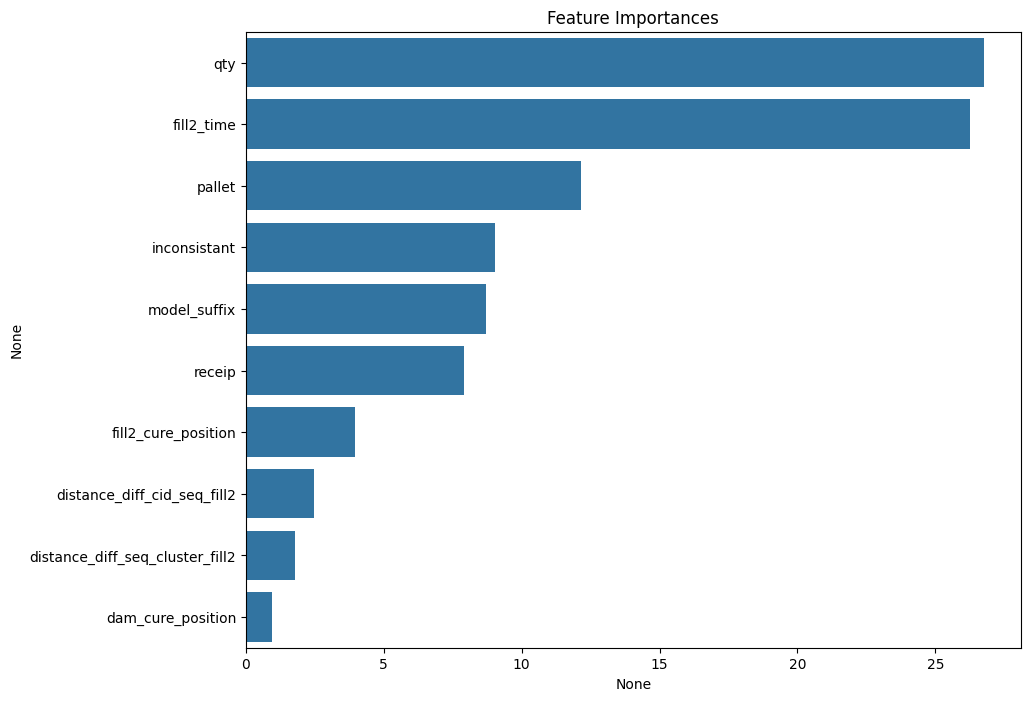

In [20]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(fill2_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [21]:
pred = fill2_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  24  434]
 [   0 7644]]

정확도: 0.9464
정밀도: 1.0000
재현율: 0.0524
F1: 0.0996


In [22]:
0.4324
0.0699

0.0699

# AutoClave

In [23]:
X_AutoClave = df_autoclave.drop(columns=['target'])
y_AutoClave = df_autoclave['target'].apply(lambda x: 0 if x == 'Normal' else 1)

cat_features_indices = ['model_suffix', 'pallet', 'receip']

X_train, X_valid, y_train, y_valid = train_test_split(X_AutoClave, y_AutoClave, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-12 06:56:09,166] A new study created in memory with name: no-name-52f6fbcf-fb7e-470f-b7f7-cd0c3bf0111c
[I 2024-08-12 06:56:13,173] Trial 0 finished with value: 0.4854566239044837 and parameters: {'iterations': 347, 'depth': 9, 'learning_rate': 0.002191217135552094, 'l2_leaf_reg': 4.111150396677064, 'border_count': 131, 'random_strength': 8.042406448661074, 'bagging_temperature': 0.8627995345063187, 'od_type': 'IncToDec', 'od_wait': 33, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.4854566239044837.
[I 2024-08-12 06:56:13,690] Trial 1 finished with value: 0.5399785502491956 and parameters: {'iterations': 131, 'depth': 6, 'learning_rate': 0.07596511346447278, 'l2_leaf_reg': 0.31428684773196797, 'border_count': 199, 'random_strength': 8.591860102443512, 'bagging_temperature': 0.2688239477661355, 'od_type': 'IncToDec', 'od_wait': 37, 'boosting_type': 'Plain'}. Best is trial 1 with value: 0.5399785502491956.
[I 2024-08-12 06:56:19,274] Trial 2 finished with value: 0.54

[I 2024-08-12 06:58:32,072] Trial 20 finished with value: 0.5517513305436723 and parameters: {'iterations': 791, 'depth': 8, 'learning_rate': 0.03055525988554265, 'l2_leaf_reg': 1.4270824152838792, 'border_count': 38, 'random_strength': 2.0030478038975947, 'bagging_temperature': 0.24321634462070432, 'od_type': 'IncToDec', 'od_wait': 38, 'boosting_type': 'Ordered'}. Best is trial 16 with value: 0.5517513305436723.
[I 2024-08-12 06:58:42,010] Trial 21 finished with value: 0.5478587134756685 and parameters: {'iterations': 845, 'depth': 7, 'learning_rate': 0.02566444288020627, 'l2_leaf_reg': 1.206672566518542, 'border_count': 39, 'random_strength': 0.03484373655335471, 'bagging_temperature': 0.22048570769381115, 'od_type': 'IncToDec', 'od_wait': 38, 'boosting_type': 'Ordered'}. Best is trial 16 with value: 0.5517513305436723.
[I 2024-08-12 06:59:01,523] Trial 22 finished with value: 0.5459006119402224 and parameters: {'iterations': 746, 'depth': 8, 'learning_rate': 0.00979885871216209, 'l2

[I 2024-08-12 07:01:10,491] Trial 40 finished with value: 0.5473850378537729 and parameters: {'iterations': 465, 'depth': 9, 'learning_rate': 0.24694494870319333, 'l2_leaf_reg': 0.03418008173960384, 'border_count': 48, 'random_strength': 0.9925883694842781, 'bagging_temperature': 0.43853529611502584, 'od_type': 'Iter', 'od_wait': 13, 'boosting_type': 'Plain'}. Best is trial 34 with value: 0.5571797933501417.
[I 2024-08-12 07:01:15,708] Trial 41 finished with value: 0.5515856407507217 and parameters: {'iterations': 534, 'depth': 4, 'learning_rate': 0.04663698327699239, 'l2_leaf_reg': 0.9073219952115998, 'border_count': 84, 'random_strength': 1.5513135483662288, 'bagging_temperature': 0.5254216606691678, 'od_type': 'Iter', 'od_wait': 18, 'boosting_type': 'Plain'}. Best is trial 34 with value: 0.5571797933501417.
[I 2024-08-12 07:01:21,882] Trial 42 finished with value: 0.5478587134756685 and parameters: {'iterations': 600, 'depth': 4, 'learning_rate': 0.034469222367743274, 'l2_leaf_reg':

Best trial:
  Value: 0.5571797933501417
  Params: 
    iterations: 675
    depth: 4
    learning_rate: 0.6688598396182069
    l2_leaf_reg: 0.7945203028770511
    border_count: 66
    random_strength: 1.7890687755344712
    bagging_temperature: 0.18217848127679964
    od_type: IncToDec
    od_wait: 36
    boosting_type: Plain


In [24]:
study.best_trial.params

{'iterations': 675,
 'depth': 4,
 'learning_rate': 0.6688598396182069,
 'l2_leaf_reg': 0.7945203028770511,
 'border_count': 66,
 'random_strength': 1.7890687755344712,
 'bagging_temperature': 0.18217848127679964,
 'od_type': 'IncToDec',
 'od_wait': 36,
 'boosting_type': 'Plain'}

In [25]:
# 최적의 하이퍼파라미터로 모델 재학습
AutoClave_best_params = study.best_trial.params
AutoClave_best_model = CatBoostClassifier(**AutoClave_best_params)
AutoClave_best_model.fit(X_train, y_train, cat_features=cat_features_indices)

0:	learn: 0.2520479	total: 10.7ms	remaining: 7.24s
1:	learn: 0.2156697	total: 22.5ms	remaining: 7.56s
2:	learn: 0.2107470	total: 32.9ms	remaining: 7.37s
3:	learn: 0.2098843	total: 45ms	remaining: 7.54s
4:	learn: 0.2093126	total: 54.5ms	remaining: 7.3s
5:	learn: 0.2083887	total: 65.1ms	remaining: 7.26s
6:	learn: 0.2075000	total: 75.4ms	remaining: 7.2s
7:	learn: 0.2074430	total: 85.5ms	remaining: 7.13s
8:	learn: 0.2072440	total: 95.9ms	remaining: 7.09s
9:	learn: 0.2067453	total: 107ms	remaining: 7.1s
10:	learn: 0.2065454	total: 118ms	remaining: 7.13s
11:	learn: 0.2062156	total: 129ms	remaining: 7.13s
12:	learn: 0.2062149	total: 136ms	remaining: 6.93s
13:	learn: 0.2061353	total: 147ms	remaining: 6.94s
14:	learn: 0.2059343	total: 158ms	remaining: 6.95s
15:	learn: 0.2057886	total: 168ms	remaining: 6.93s
16:	learn: 0.2055862	total: 180ms	remaining: 6.96s
17:	learn: 0.2053690	total: 189ms	remaining: 6.91s
18:	learn: 0.2051726	total: 200ms	remaining: 6.89s
19:	learn: 0.2045532	total: 213ms	rem

166:	learn: 0.1791788	total: 1.81s	remaining: 5.5s
167:	learn: 0.1791215	total: 1.82s	remaining: 5.5s
168:	learn: 0.1789860	total: 1.83s	remaining: 5.49s
169:	learn: 0.1788304	total: 1.84s	remaining: 5.47s
170:	learn: 0.1787662	total: 1.85s	remaining: 5.46s
171:	learn: 0.1787304	total: 1.87s	remaining: 5.46s
172:	learn: 0.1785518	total: 1.88s	remaining: 5.45s
173:	learn: 0.1784614	total: 1.89s	remaining: 5.44s
174:	learn: 0.1783352	total: 1.9s	remaining: 5.42s
175:	learn: 0.1782382	total: 1.91s	remaining: 5.42s
176:	learn: 0.1780359	total: 1.92s	remaining: 5.41s
177:	learn: 0.1778039	total: 1.93s	remaining: 5.4s
178:	learn: 0.1777601	total: 1.94s	remaining: 5.39s
179:	learn: 0.1776518	total: 1.96s	remaining: 5.38s
180:	learn: 0.1775046	total: 1.97s	remaining: 5.36s
181:	learn: 0.1774883	total: 1.98s	remaining: 5.36s
182:	learn: 0.1773167	total: 1.99s	remaining: 5.35s
183:	learn: 0.1772755	total: 2s	remaining: 5.34s
184:	learn: 0.1771656	total: 2.01s	remaining: 5.32s
185:	learn: 0.17695

336:	learn: 0.1630647	total: 3.67s	remaining: 3.68s
337:	learn: 0.1629895	total: 3.68s	remaining: 3.67s
338:	learn: 0.1628830	total: 3.69s	remaining: 3.66s
339:	learn: 0.1628762	total: 3.7s	remaining: 3.65s
340:	learn: 0.1627871	total: 3.71s	remaining: 3.64s
341:	learn: 0.1627436	total: 3.72s	remaining: 3.63s
342:	learn: 0.1626872	total: 3.73s	remaining: 3.62s
343:	learn: 0.1626614	total: 3.75s	remaining: 3.6s
344:	learn: 0.1624823	total: 3.76s	remaining: 3.59s
345:	learn: 0.1623324	total: 3.77s	remaining: 3.58s
346:	learn: 0.1621562	total: 3.78s	remaining: 3.57s
347:	learn: 0.1620582	total: 3.79s	remaining: 3.56s
348:	learn: 0.1619995	total: 3.8s	remaining: 3.55s
349:	learn: 0.1618414	total: 3.81s	remaining: 3.54s
350:	learn: 0.1617650	total: 3.83s	remaining: 3.53s
351:	learn: 0.1615792	total: 3.84s	remaining: 3.52s
352:	learn: 0.1615654	total: 3.85s	remaining: 3.51s
353:	learn: 0.1615328	total: 3.86s	remaining: 3.5s
354:	learn: 0.1615137	total: 3.87s	remaining: 3.49s
355:	learn: 0.16

504:	learn: 0.1481692	total: 5.52s	remaining: 1.86s
505:	learn: 0.1480012	total: 5.53s	remaining: 1.85s
506:	learn: 0.1479308	total: 5.54s	remaining: 1.84s
507:	learn: 0.1478251	total: 5.56s	remaining: 1.83s
508:	learn: 0.1477396	total: 5.57s	remaining: 1.81s
509:	learn: 0.1476616	total: 5.58s	remaining: 1.8s
510:	learn: 0.1475726	total: 5.59s	remaining: 1.79s
511:	learn: 0.1474273	total: 5.6s	remaining: 1.78s
512:	learn: 0.1473369	total: 5.61s	remaining: 1.77s
513:	learn: 0.1472331	total: 5.62s	remaining: 1.76s
514:	learn: 0.1470391	total: 5.63s	remaining: 1.75s
515:	learn: 0.1469875	total: 5.64s	remaining: 1.74s
516:	learn: 0.1468912	total: 5.65s	remaining: 1.73s
517:	learn: 0.1468619	total: 5.66s	remaining: 1.72s
518:	learn: 0.1467978	total: 5.68s	remaining: 1.71s
519:	learn: 0.1467483	total: 5.69s	remaining: 1.7s
520:	learn: 0.1466790	total: 5.7s	remaining: 1.68s
521:	learn: 0.1465652	total: 5.71s	remaining: 1.67s
522:	learn: 0.1464757	total: 5.72s	remaining: 1.66s
523:	learn: 0.14

672:	learn: 0.1351194	total: 7.37s	remaining: 21.9ms
673:	learn: 0.1349763	total: 7.38s	remaining: 10.9ms
674:	learn: 0.1349101	total: 7.39s	remaining: 0us


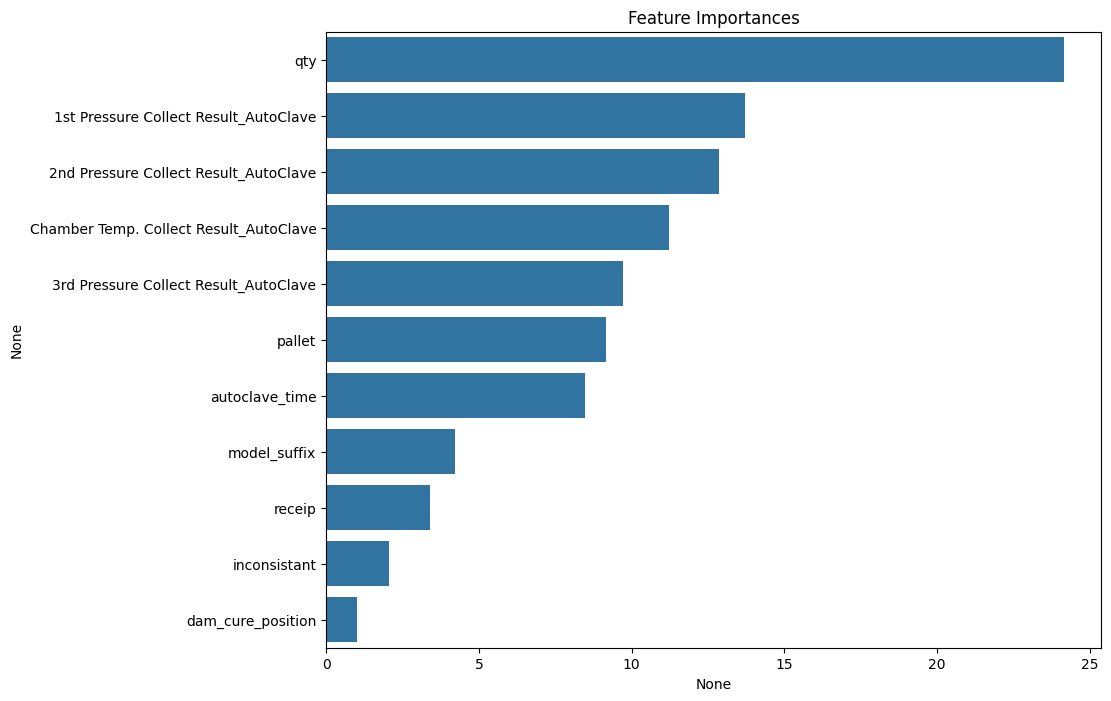

In [26]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(AutoClave_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [27]:
pred = AutoClave_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  40  418]
 [  35 7609]]

정확도: 0.9441
정밀도: 0.5333
재현율: 0.0873
F1: 0.1501


# 민감성

In [28]:
# 최적의 하이퍼파라미터로 모델 재학습
dam_best_params = study.best_trial.params
dam_best_model = CatBoostClassifier(**dam_best_params)
dam_best_model.fit(X_dam, y_dam, cat_features=cat_features_indices)

# 최적의 하이퍼파라미터로 모델 재학습
fill1_best_params = study.best_trial.params
fill1_best_model = CatBoostClassifier(**fill1_best_params)
fill1_best_model.fit(X_fill1, y_fill1, cat_features=cat_features_indices)

# 최적의 하이퍼파라미터로 모델 재학습
fill2_best_params = study.best_trial.params
fill2_best_model = CatBoostClassifier(**fill2_best_params)
fill2_best_model.fit(X_fill2, y_fill2, cat_features=cat_features_indices)

# 최적의 하이퍼파라미터로 모델 재학습
AutoClave_best_params = study.best_trial.params
AutoClave_best_model = CatBoostClassifier(**AutoClave_best_params)
AutoClave_best_model.fit(X_AutoClave, y_AutoClave, cat_features=cat_features_indices)

0:	learn: 0.2491950	total: 15.1ms	remaining: 10.2s
1:	learn: 0.2151775	total: 29.8ms	remaining: 10s
2:	learn: 0.2099274	total: 44.9ms	remaining: 10.1s
3:	learn: 0.2090607	total: 59.2ms	remaining: 9.92s
4:	learn: 0.2086222	total: 73ms	remaining: 9.78s
5:	learn: 0.2079388	total: 87.8ms	remaining: 9.79s
6:	learn: 0.2077589	total: 102ms	remaining: 9.77s
7:	learn: 0.2075470	total: 115ms	remaining: 9.56s
8:	learn: 0.2074685	total: 130ms	remaining: 9.65s
9:	learn: 0.2071739	total: 144ms	remaining: 9.6s
10:	learn: 0.2068081	total: 160ms	remaining: 9.63s
11:	learn: 0.2065666	total: 174ms	remaining: 9.61s
12:	learn: 0.2065419	total: 188ms	remaining: 9.55s
13:	learn: 0.2062862	total: 201ms	remaining: 9.5s
14:	learn: 0.2062672	total: 214ms	remaining: 9.41s
15:	learn: 0.2058328	total: 229ms	remaining: 9.45s
16:	learn: 0.2052990	total: 244ms	remaining: 9.45s
17:	learn: 0.2048478	total: 257ms	remaining: 9.38s
18:	learn: 0.2047146	total: 271ms	remaining: 9.36s
19:	learn: 0.2045494	total: 285ms	remaini

161:	learn: 0.1849036	total: 2.29s	remaining: 7.27s
162:	learn: 0.1848604	total: 2.31s	remaining: 7.25s
163:	learn: 0.1847781	total: 2.32s	remaining: 7.24s
164:	learn: 0.1847405	total: 2.34s	remaining: 7.23s
165:	learn: 0.1847071	total: 2.35s	remaining: 7.21s
166:	learn: 0.1845959	total: 2.37s	remaining: 7.2s
167:	learn: 0.1844138	total: 2.38s	remaining: 7.19s
168:	learn: 0.1843869	total: 2.39s	remaining: 7.17s
169:	learn: 0.1841978	total: 2.41s	remaining: 7.15s
170:	learn: 0.1841267	total: 2.42s	remaining: 7.14s
171:	learn: 0.1839869	total: 2.44s	remaining: 7.12s
172:	learn: 0.1839370	total: 2.45s	remaining: 7.11s
173:	learn: 0.1839210	total: 2.46s	remaining: 7.09s
174:	learn: 0.1838727	total: 2.48s	remaining: 7.08s
175:	learn: 0.1837237	total: 2.49s	remaining: 7.07s
176:	learn: 0.1836202	total: 2.51s	remaining: 7.06s
177:	learn: 0.1835051	total: 2.52s	remaining: 7.04s
178:	learn: 0.1833558	total: 2.54s	remaining: 7.03s
179:	learn: 0.1833442	total: 2.55s	remaining: 7.02s
180:	learn: 0

324:	learn: 0.1716308	total: 4.6s	remaining: 4.95s
325:	learn: 0.1715419	total: 4.61s	remaining: 4.94s
326:	learn: 0.1714431	total: 4.63s	remaining: 4.92s
327:	learn: 0.1713795	total: 4.64s	remaining: 4.91s
328:	learn: 0.1713245	total: 4.65s	remaining: 4.89s
329:	learn: 0.1712853	total: 4.67s	remaining: 4.88s
330:	learn: 0.1712122	total: 4.68s	remaining: 4.86s
331:	learn: 0.1711444	total: 4.69s	remaining: 4.85s
332:	learn: 0.1710844	total: 4.71s	remaining: 4.83s
333:	learn: 0.1710432	total: 4.72s	remaining: 4.82s
334:	learn: 0.1709910	total: 4.74s	remaining: 4.81s
335:	learn: 0.1709187	total: 4.75s	remaining: 4.79s
336:	learn: 0.1708447	total: 4.77s	remaining: 4.78s
337:	learn: 0.1707528	total: 4.78s	remaining: 4.77s
338:	learn: 0.1706816	total: 4.79s	remaining: 4.75s
339:	learn: 0.1706093	total: 4.81s	remaining: 4.74s
340:	learn: 0.1704948	total: 4.83s	remaining: 4.73s
341:	learn: 0.1704558	total: 4.84s	remaining: 4.71s
342:	learn: 0.1703680	total: 4.85s	remaining: 4.7s
343:	learn: 0.

484:	learn: 0.1611951	total: 6.9s	remaining: 2.7s
485:	learn: 0.1611287	total: 6.92s	remaining: 2.69s
486:	learn: 0.1610716	total: 6.93s	remaining: 2.67s
487:	learn: 0.1609104	total: 6.95s	remaining: 2.66s
488:	learn: 0.1608367	total: 6.96s	remaining: 2.65s
489:	learn: 0.1607601	total: 6.97s	remaining: 2.63s
490:	learn: 0.1607241	total: 6.99s	remaining: 2.62s
491:	learn: 0.1606918	total: 7s	remaining: 2.6s
492:	learn: 0.1606093	total: 7.01s	remaining: 2.59s
493:	learn: 0.1605964	total: 7.03s	remaining: 2.58s
494:	learn: 0.1605172	total: 7.04s	remaining: 2.56s
495:	learn: 0.1604548	total: 7.06s	remaining: 2.55s
496:	learn: 0.1604006	total: 7.07s	remaining: 2.53s
497:	learn: 0.1602649	total: 7.08s	remaining: 2.52s
498:	learn: 0.1602140	total: 7.1s	remaining: 2.5s
499:	learn: 0.1601804	total: 7.12s	remaining: 2.49s
500:	learn: 0.1601203	total: 7.13s	remaining: 2.48s
501:	learn: 0.1599910	total: 7.15s	remaining: 2.46s
502:	learn: 0.1598824	total: 7.16s	remaining: 2.45s
503:	learn: 0.159814

645:	learn: 0.1531100	total: 9.21s	remaining: 413ms
646:	learn: 0.1530963	total: 9.22s	remaining: 399ms
647:	learn: 0.1530819	total: 9.23s	remaining: 385ms
648:	learn: 0.1529975	total: 9.25s	remaining: 371ms
649:	learn: 0.1528994	total: 9.26s	remaining: 356ms
650:	learn: 0.1528839	total: 9.28s	remaining: 342ms
651:	learn: 0.1528750	total: 9.29s	remaining: 328ms
652:	learn: 0.1528593	total: 9.3s	remaining: 313ms
653:	learn: 0.1528441	total: 9.32s	remaining: 299ms
654:	learn: 0.1528206	total: 9.33s	remaining: 285ms
655:	learn: 0.1527974	total: 9.35s	remaining: 271ms
656:	learn: 0.1527258	total: 9.36s	remaining: 256ms
657:	learn: 0.1526956	total: 9.37s	remaining: 242ms
658:	learn: 0.1526487	total: 9.39s	remaining: 228ms
659:	learn: 0.1526030	total: 9.4s	remaining: 214ms
660:	learn: 0.1525745	total: 9.42s	remaining: 199ms
661:	learn: 0.1525425	total: 9.43s	remaining: 185ms
662:	learn: 0.1524941	total: 9.44s	remaining: 171ms
663:	learn: 0.1523494	total: 9.46s	remaining: 157ms
664:	learn: 0.

130:	learn: 0.1882479	total: 1.76s	remaining: 7.32s
131:	learn: 0.1880975	total: 1.78s	remaining: 7.31s
132:	learn: 0.1879724	total: 1.79s	remaining: 7.29s
133:	learn: 0.1879115	total: 1.8s	remaining: 7.27s
134:	learn: 0.1876761	total: 1.81s	remaining: 7.26s
135:	learn: 0.1876587	total: 1.83s	remaining: 7.25s
136:	learn: 0.1875443	total: 1.84s	remaining: 7.24s
137:	learn: 0.1874410	total: 1.86s	remaining: 7.22s
138:	learn: 0.1873929	total: 1.87s	remaining: 7.2s
139:	learn: 0.1873355	total: 1.88s	remaining: 7.19s
140:	learn: 0.1872780	total: 1.89s	remaining: 7.17s
141:	learn: 0.1872505	total: 1.91s	remaining: 7.16s
142:	learn: 0.1871855	total: 1.92s	remaining: 7.15s
143:	learn: 0.1871333	total: 1.94s	remaining: 7.13s
144:	learn: 0.1871019	total: 1.95s	remaining: 7.12s
145:	learn: 0.1869413	total: 1.96s	remaining: 7.11s
146:	learn: 0.1868585	total: 1.98s	remaining: 7.1s
147:	learn: 0.1868187	total: 1.99s	remaining: 7.08s
148:	learn: 0.1866735	total: 2s	remaining: 7.07s
149:	learn: 0.1865

300:	learn: 0.1749287	total: 4.02s	remaining: 4.99s
301:	learn: 0.1748188	total: 4.03s	remaining: 4.98s
302:	learn: 0.1748105	total: 4.05s	remaining: 4.97s
303:	learn: 0.1747827	total: 4.06s	remaining: 4.96s
304:	learn: 0.1747214	total: 4.07s	remaining: 4.94s
305:	learn: 0.1746568	total: 4.09s	remaining: 4.93s
306:	learn: 0.1746074	total: 4.1s	remaining: 4.91s
307:	learn: 0.1744943	total: 4.11s	remaining: 4.9s
308:	learn: 0.1744926	total: 4.13s	remaining: 4.89s
309:	learn: 0.1744627	total: 4.14s	remaining: 4.87s
310:	learn: 0.1743366	total: 4.15s	remaining: 4.86s
311:	learn: 0.1743009	total: 4.17s	remaining: 4.85s
312:	learn: 0.1742104	total: 4.18s	remaining: 4.83s
313:	learn: 0.1741884	total: 4.19s	remaining: 4.82s
314:	learn: 0.1741742	total: 4.21s	remaining: 4.81s
315:	learn: 0.1740746	total: 4.22s	remaining: 4.79s
316:	learn: 0.1740475	total: 4.23s	remaining: 4.78s
317:	learn: 0.1739767	total: 4.25s	remaining: 4.77s
318:	learn: 0.1739251	total: 4.26s	remaining: 4.76s
319:	learn: 0.

467:	learn: 0.1642871	total: 6.28s	remaining: 2.78s
468:	learn: 0.1642242	total: 6.29s	remaining: 2.76s
469:	learn: 0.1641209	total: 6.3s	remaining: 2.75s
470:	learn: 0.1641021	total: 6.32s	remaining: 2.74s
471:	learn: 0.1640621	total: 6.33s	remaining: 2.72s
472:	learn: 0.1640440	total: 6.35s	remaining: 2.71s
473:	learn: 0.1640433	total: 6.36s	remaining: 2.7s
474:	learn: 0.1640032	total: 6.37s	remaining: 2.68s
475:	learn: 0.1639360	total: 6.38s	remaining: 2.67s
476:	learn: 0.1639195	total: 6.4s	remaining: 2.65s
477:	learn: 0.1638615	total: 6.41s	remaining: 2.64s
478:	learn: 0.1637709	total: 6.42s	remaining: 2.63s
479:	learn: 0.1637325	total: 6.44s	remaining: 2.62s
480:	learn: 0.1635876	total: 6.45s	remaining: 2.6s
481:	learn: 0.1635585	total: 6.46s	remaining: 2.59s
482:	learn: 0.1635010	total: 6.48s	remaining: 2.58s
483:	learn: 0.1634938	total: 6.49s	remaining: 2.56s
484:	learn: 0.1634780	total: 6.51s	remaining: 2.55s
485:	learn: 0.1634240	total: 6.52s	remaining: 2.54s
486:	learn: 0.16

636:	learn: 0.1550228	total: 8.55s	remaining: 510ms
637:	learn: 0.1550046	total: 8.57s	remaining: 497ms
638:	learn: 0.1549745	total: 8.58s	remaining: 483ms
639:	learn: 0.1549335	total: 8.59s	remaining: 470ms
640:	learn: 0.1548560	total: 8.61s	remaining: 457ms
641:	learn: 0.1548346	total: 8.62s	remaining: 443ms
642:	learn: 0.1548075	total: 8.63s	remaining: 430ms
643:	learn: 0.1547116	total: 8.65s	remaining: 416ms
644:	learn: 0.1546614	total: 8.66s	remaining: 403ms
645:	learn: 0.1545901	total: 8.67s	remaining: 389ms
646:	learn: 0.1545635	total: 8.69s	remaining: 376ms
647:	learn: 0.1545116	total: 8.7s	remaining: 362ms
648:	learn: 0.1544902	total: 8.71s	remaining: 349ms
649:	learn: 0.1544159	total: 8.73s	remaining: 336ms
650:	learn: 0.1543080	total: 8.74s	remaining: 322ms
651:	learn: 0.1542653	total: 8.76s	remaining: 309ms
652:	learn: 0.1541808	total: 8.77s	remaining: 296ms
653:	learn: 0.1541670	total: 8.78s	remaining: 282ms
654:	learn: 0.1541162	total: 8.8s	remaining: 269ms
655:	learn: 0.

132:	learn: 0.1962248	total: 1.66s	remaining: 6.77s
133:	learn: 0.1961752	total: 1.67s	remaining: 6.76s
134:	learn: 0.1961713	total: 1.69s	remaining: 6.75s
135:	learn: 0.1959668	total: 1.7s	remaining: 6.74s
136:	learn: 0.1959189	total: 1.71s	remaining: 6.73s
137:	learn: 0.1958992	total: 1.73s	remaining: 6.72s
138:	learn: 0.1958135	total: 1.74s	remaining: 6.7s
139:	learn: 0.1957566	total: 1.75s	remaining: 6.7s
140:	learn: 0.1956651	total: 1.77s	remaining: 6.69s
141:	learn: 0.1955574	total: 1.78s	remaining: 6.67s
142:	learn: 0.1955451	total: 1.79s	remaining: 6.67s
143:	learn: 0.1955081	total: 1.81s	remaining: 6.66s
144:	learn: 0.1954105	total: 1.82s	remaining: 6.65s
145:	learn: 0.1952639	total: 1.83s	remaining: 6.64s
146:	learn: 0.1952201	total: 1.84s	remaining: 6.63s
147:	learn: 0.1952160	total: 1.86s	remaining: 6.62s
148:	learn: 0.1951268	total: 1.87s	remaining: 6.6s
149:	learn: 0.1950296	total: 1.88s	remaining: 6.59s
150:	learn: 0.1948912	total: 1.9s	remaining: 6.58s
151:	learn: 0.194

291:	learn: 0.1860313	total: 3.72s	remaining: 4.88s
292:	learn: 0.1860176	total: 3.73s	remaining: 4.87s
293:	learn: 0.1860113	total: 3.75s	remaining: 4.85s
294:	learn: 0.1859113	total: 3.76s	remaining: 4.84s
295:	learn: 0.1858878	total: 3.77s	remaining: 4.83s
296:	learn: 0.1857964	total: 3.79s	remaining: 4.82s
297:	learn: 0.1857323	total: 3.8s	remaining: 4.81s
298:	learn: 0.1856926	total: 3.81s	remaining: 4.8s
299:	learn: 0.1856512	total: 3.83s	remaining: 4.78s
300:	learn: 0.1856271	total: 3.84s	remaining: 4.77s
301:	learn: 0.1856049	total: 3.85s	remaining: 4.76s
302:	learn: 0.1855636	total: 3.86s	remaining: 4.74s
303:	learn: 0.1855550	total: 3.88s	remaining: 4.73s
304:	learn: 0.1855128	total: 3.89s	remaining: 4.72s
305:	learn: 0.1854651	total: 3.9s	remaining: 4.7s
306:	learn: 0.1853903	total: 3.91s	remaining: 4.69s
307:	learn: 0.1853615	total: 3.93s	remaining: 4.68s
308:	learn: 0.1853220	total: 3.94s	remaining: 4.67s
309:	learn: 0.1852994	total: 3.96s	remaining: 4.66s
310:	learn: 0.18

451:	learn: 0.1784033	total: 5.78s	remaining: 2.85s
452:	learn: 0.1783454	total: 5.79s	remaining: 2.84s
453:	learn: 0.1783177	total: 5.81s	remaining: 2.83s
454:	learn: 0.1782574	total: 5.82s	remaining: 2.81s
455:	learn: 0.1781732	total: 5.84s	remaining: 2.8s
456:	learn: 0.1781188	total: 5.85s	remaining: 2.79s
457:	learn: 0.1780963	total: 5.87s	remaining: 2.78s
458:	learn: 0.1780413	total: 5.88s	remaining: 2.77s
459:	learn: 0.1780182	total: 5.89s	remaining: 2.75s
460:	learn: 0.1779767	total: 5.9s	remaining: 2.74s
461:	learn: 0.1779398	total: 5.92s	remaining: 2.73s
462:	learn: 0.1778955	total: 5.93s	remaining: 2.71s
463:	learn: 0.1778675	total: 5.94s	remaining: 2.7s
464:	learn: 0.1778085	total: 5.95s	remaining: 2.69s
465:	learn: 0.1777258	total: 5.96s	remaining: 2.67s
466:	learn: 0.1777043	total: 5.98s	remaining: 2.66s
467:	learn: 0.1776814	total: 5.99s	remaining: 2.65s
468:	learn: 0.1776437	total: 6s	remaining: 2.64s
469:	learn: 0.1775642	total: 6.02s	remaining: 2.63s
470:	learn: 0.1775

611:	learn: 0.1720694	total: 7.85s	remaining: 808ms
612:	learn: 0.1720382	total: 7.86s	remaining: 795ms
613:	learn: 0.1720146	total: 7.87s	remaining: 782ms
614:	learn: 0.1719729	total: 7.89s	remaining: 770ms
615:	learn: 0.1719478	total: 7.9s	remaining: 757ms
616:	learn: 0.1719119	total: 7.91s	remaining: 744ms
617:	learn: 0.1718947	total: 7.93s	remaining: 731ms
618:	learn: 0.1718539	total: 7.94s	remaining: 718ms
619:	learn: 0.1717809	total: 7.95s	remaining: 706ms
620:	learn: 0.1717695	total: 7.97s	remaining: 693ms
621:	learn: 0.1716685	total: 7.98s	remaining: 680ms
622:	learn: 0.1716383	total: 7.99s	remaining: 667ms
623:	learn: 0.1716021	total: 8s	remaining: 654ms
624:	learn: 0.1715122	total: 8.02s	remaining: 641ms
625:	learn: 0.1714893	total: 8.03s	remaining: 629ms
626:	learn: 0.1714768	total: 8.04s	remaining: 616ms
627:	learn: 0.1714262	total: 8.06s	remaining: 603ms
628:	learn: 0.1713324	total: 8.07s	remaining: 590ms
629:	learn: 0.1713098	total: 8.08s	remaining: 577ms
630:	learn: 0.17

100:	learn: 0.1896543	total: 1.35s	remaining: 7.69s
101:	learn: 0.1896159	total: 1.37s	remaining: 7.68s
102:	learn: 0.1892708	total: 1.38s	remaining: 7.66s
103:	learn: 0.1890876	total: 1.39s	remaining: 7.64s
104:	learn: 0.1890409	total: 1.4s	remaining: 7.62s
105:	learn: 0.1888791	total: 1.42s	remaining: 7.61s
106:	learn: 0.1888137	total: 1.43s	remaining: 7.6s
107:	learn: 0.1887742	total: 1.44s	remaining: 7.57s
108:	learn: 0.1887034	total: 1.46s	remaining: 7.56s
109:	learn: 0.1886405	total: 1.47s	remaining: 7.55s
110:	learn: 0.1884530	total: 1.48s	remaining: 7.54s
111:	learn: 0.1884178	total: 1.5s	remaining: 7.53s
112:	learn: 0.1882707	total: 1.51s	remaining: 7.53s
113:	learn: 0.1882258	total: 1.53s	remaining: 7.52s
114:	learn: 0.1881835	total: 1.54s	remaining: 7.51s
115:	learn: 0.1880793	total: 1.56s	remaining: 7.5s
116:	learn: 0.1879617	total: 1.57s	remaining: 7.49s
117:	learn: 0.1878151	total: 1.58s	remaining: 7.47s
118:	learn: 0.1876872	total: 1.6s	remaining: 7.46s
119:	learn: 0.187

272:	learn: 0.1730838	total: 3.62s	remaining: 5.32s
273:	learn: 0.1730106	total: 3.63s	remaining: 5.31s
274:	learn: 0.1729601	total: 3.65s	remaining: 5.3s
275:	learn: 0.1729129	total: 3.66s	remaining: 5.29s
276:	learn: 0.1727343	total: 3.67s	remaining: 5.27s
277:	learn: 0.1726324	total: 3.68s	remaining: 5.26s
278:	learn: 0.1725769	total: 3.7s	remaining: 5.25s
279:	learn: 0.1725123	total: 3.71s	remaining: 5.23s
280:	learn: 0.1723712	total: 3.72s	remaining: 5.22s
281:	learn: 0.1723044	total: 3.73s	remaining: 5.21s
282:	learn: 0.1722719	total: 3.75s	remaining: 5.19s
283:	learn: 0.1721175	total: 3.76s	remaining: 5.18s
284:	learn: 0.1721100	total: 3.78s	remaining: 5.17s
285:	learn: 0.1720744	total: 3.79s	remaining: 5.16s
286:	learn: 0.1720236	total: 3.8s	remaining: 5.14s
287:	learn: 0.1718925	total: 3.82s	remaining: 5.13s
288:	learn: 0.1718343	total: 3.83s	remaining: 5.12s
289:	learn: 0.1718129	total: 3.84s	remaining: 5.1s
290:	learn: 0.1716805	total: 3.86s	remaining: 5.09s
291:	learn: 0.17

442:	learn: 0.1606935	total: 5.86s	remaining: 3.07s
443:	learn: 0.1606764	total: 5.88s	remaining: 3.06s
444:	learn: 0.1606296	total: 5.89s	remaining: 3.04s
445:	learn: 0.1605551	total: 5.9s	remaining: 3.03s
446:	learn: 0.1605389	total: 5.92s	remaining: 3.02s
447:	learn: 0.1604066	total: 5.93s	remaining: 3s
448:	learn: 0.1603325	total: 5.94s	remaining: 2.99s
449:	learn: 0.1602270	total: 5.96s	remaining: 2.98s
450:	learn: 0.1601238	total: 5.97s	remaining: 2.96s
451:	learn: 0.1600180	total: 5.98s	remaining: 2.95s
452:	learn: 0.1600121	total: 6s	remaining: 2.94s
453:	learn: 0.1599128	total: 6.01s	remaining: 2.93s
454:	learn: 0.1598637	total: 6.03s	remaining: 2.91s
455:	learn: 0.1597362	total: 6.04s	remaining: 2.9s
456:	learn: 0.1596851	total: 6.05s	remaining: 2.89s
457:	learn: 0.1596630	total: 6.06s	remaining: 2.87s
458:	learn: 0.1596411	total: 6.08s	remaining: 2.86s
459:	learn: 0.1595656	total: 6.09s	remaining: 2.85s
460:	learn: 0.1595380	total: 6.11s	remaining: 2.83s
461:	learn: 0.159451

614:	learn: 0.1498136	total: 8.15s	remaining: 795ms
615:	learn: 0.1497996	total: 8.16s	remaining: 782ms
616:	learn: 0.1497643	total: 8.18s	remaining: 769ms
617:	learn: 0.1497363	total: 8.19s	remaining: 756ms
618:	learn: 0.1496375	total: 8.21s	remaining: 742ms
619:	learn: 0.1496329	total: 8.22s	remaining: 729ms
620:	learn: 0.1495677	total: 8.23s	remaining: 716ms
621:	learn: 0.1495249	total: 8.24s	remaining: 702ms
622:	learn: 0.1494100	total: 8.26s	remaining: 689ms
623:	learn: 0.1493446	total: 8.27s	remaining: 676ms
624:	learn: 0.1493047	total: 8.28s	remaining: 663ms
625:	learn: 0.1491817	total: 8.3s	remaining: 649ms
626:	learn: 0.1491250	total: 8.31s	remaining: 636ms
627:	learn: 0.1490811	total: 8.32s	remaining: 623ms
628:	learn: 0.1490662	total: 8.33s	remaining: 609ms
629:	learn: 0.1489682	total: 8.34s	remaining: 596ms
630:	learn: 0.1489412	total: 8.36s	remaining: 583ms
631:	learn: 0.1488866	total: 8.37s	remaining: 570ms
632:	learn: 0.1487877	total: 8.38s	remaining: 556ms
633:	learn: 0

In [29]:
dam

['target',
 'inconsistant',
 'dam_cure_position',
 'model_suffix',
 'cure_speed_dam',
 'discharged_speed_dam',
 'cid_time_dam',
 'seq_time_dam',
 'cluster_time_dam',
 'cid_volume_dam',
 'Seq_volume_dam',
 'cluster_volume_dam',
 'distance_diff_cid_seq_dam',
 'distance_diff_seq_cluster_dam',
 'dam_time',
 'pallet',
 'qty',
 'receip',
 'Stage1 Circle1 Distance Speed Collect Result_Dam',
 'Stage1 Circle2 Distance Speed Collect Result_Dam',
 'Stage1 Circle3 Distance Speed Collect Result_Dam',
 'Stage1 Circle4 Distance Speed Collect Result_Dam',
 'Stage1 Line1 Distance Speed Collect Result_Dam',
 'Stage1 Line2 Distance Speed Collect Result_Dam',
 'Stage1 Line3 Distance Speed Collect Result_Dam',
 'Stage1 Line4 Distance Speed Collect Result_Dam',
 'Stage2 Circle1 Distance Speed Collect Result_Dam',
 'Stage2 Circle2 Distance Speed Collect Result_Dam',
 'Stage2 Circle3 Distance Speed Collect Result_Dam',
 'Stage2 Circle4 Distance Speed Collect Result_Dam',
 'Stage2 Line1 Distance Speed Collect 

In [30]:
test_dam_x = test[X_dam.columns]
test_fill1_x = test[X_fill1.columns]
test_fill2_x = test[X_fill2.columns]
test_AutoClave_x = test[X_AutoClave.columns]

In [31]:
dam_test_pred = dam_best_model.predict(test_dam_x)
dam_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [32]:
fill1_test_pred = fill1_best_model.predict(test_fill1_x)
fill1_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [33]:
fill2_test_pred = fill2_best_model.predict(test_fill2_x)
fill2_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [34]:
AutoClave_test_pred = AutoClave_best_model.predict(test_AutoClave_x)
AutoClave_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [35]:
result = np.logical_and(dam_test_pred, fill1_test_pred)
result = np.logical_and(result, fill2_test_pred)
result = np.logical_and(result, AutoClave_test_pred)

In [41]:
y_pred = np.where(result == 1, "AbNormal", "Normal")

In [42]:
np.unique(y_pred, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([   50, 17311]))

In [43]:
test['target'] = y_pred

In [44]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,22,17311
1,28,0


In [40]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = y_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)